In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

#The rainfall dataset is loaded and a basic inspection is performed to understand the distribution of key categorical variables. The frequency of observations within the rainy and non-rainy seasons is examined using the is_rainy_season variable. Additionally, the version variable is checked to confirm the consistency of data sources within the dataset.The rainfall dataset is loaded and a basic inspection is performed to understand the distribution of key categorical variables. The frequency of observations within the rainy and non-rainy seasons is examined using the is_rainy_season variable. Additionally, the version variable is checked to confirm the consistency of data sources within the dataset.

In [82]:
rainfall = pd.read_csv('Rainfall.csv')
rainfall['is_rainy_season'].value_counts()
rainfall['version'].value_counts()

version
final       24165
prelim         60
forecast       15
Name: count, dtype: int64

#The unnamed index column in the dataset is renamed to ID to improve clarity and make the dataset easier to interpret during analysis.

In [84]:
rainfall.rename(columns={'Unnamed: 0':'ID'})

,ID,date,adm_level,adm_id,PCODE,Name,Municipality,n_pixels,rfh,rfh_avg,...,dekad_of_month,is_rainy_season,sin_month,cos_month,drought_flag,high_rainfall_flag,r3h_6m_ma,r3h_12m_ma,rfh_3d_std,rfh_rate_change
0,203616,1981-01-01,2,1009451,GH0705,Ada East,Greater Accra,7.0,2.857143,3.504762,...,1,0,0.500000,0.866025,0,0,208.147033,208.147033,0.000000,2.857143
1,203617,1981-01-11,2,1009451,GH0705,Ada East,Greater Accra,7.0,2.285714,2.633333,...,2,0,0.500000,0.866025,0,0,208.147033,208.147033,0.404061,-0.571429
2,203618,1981-01-21,2,1009451,GH0705,Ada East,Greater Accra,7.0,6.000000,5.171429,...,3,0,0.500000,0.866025,0,1,208.147033,208.147033,2.000000,3.714286
3,203619,1981-02-01,2,1009451,GH0705,Ada East,Greater Accra,7.0,2.571429,3.576191,...,1,0,0.866025,0.500000,0,0,208.147033,208.147033,2.066908,-3.428571
4,203620,1981-02-11,2,1009451,GH0705,Ada East,Greater Accra,7.0,7.285714,7.752381,...,2,0,0.866025,0.500000,0,0,208.147033,208.147033,2.436960,4.714285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24235,357131,2025-10-01,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,57.500000,28.366667,...,1,1,-0.866025,0.500000,0,1,282.500000,204.166667,12.273786,19.750000
24236,357132,2025-10-11,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,61.000000,33.058334,...,2,1,-0.866025,0.500000,0,1,286.861111,206.743056,12.535782,3.500000
24237,357133,2025-10-21,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,23.000000,30.616667,...,3,1,-0.866025,0.500000,0,0,288.708333,209.013889,21.001984,-38.000000
24238,357134,2025-11-01,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,26.250000,12.725000,...,1,0,-0.500000,0.866025,0,1,289.888889,211.201389,21.063891,3.250000


# Dataset Structure

The info() function is used to display the structure of the dataset, including the number of entries, column names, data types, and non-null values. This helps verify data completeness and identify any potential issues such as missing values or incorrect data types.

In [86]:
rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24240 entries, 0 to 24239
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          24240 non-null  int64  
 1   date                24240 non-null  object 
 2   adm_level           24240 non-null  int64  
 3   adm_id              24240 non-null  int64  
 4   PCODE               24240 non-null  object 
 5   Name                24240 non-null  object 
 6   Municipality        24240 non-null  object 
 7   n_pixels            24240 non-null  float64
 8   rfh                 24240 non-null  float64
 9   rfh_avg             24240 non-null  float64
 10  r1h                 24240 non-null  float64
 11  r1h_avg             24240 non-null  float64
 12  r3h                 24240 non-null  float64
 13  r3h_avg             24240 non-null  float64
 14  rfq                 24240 non-null  float64
 15  r1q                 24240 non-null  float64
 16  r3q 

# Target Variable Distribution

The variable high_rainfall_flag is selected as the target variable for this analysis. The value_counts() function is used to examine the distribution of high rainfall events versus normal rainfall events, providing insight into class balance within the dataset.

In [88]:
rainfall['high_rainfall_flag'].value_counts()

high_rainfall_flag
0    14377
1     9863
Name: count, dtype: int64

Certain columns are identified for removal to improve the quality of the analysis. Identifier and location-related columns that do not contribute meaningful information to pattern analysis are excluded. In addition, variables that directly reflect current rainfall measurements are removed to prevent information leakage and ensure a fair and reliable prediction.

In [90]:
ids_to_drop = [
    "Unnamed: 0", "date", "adm_level", "adm_id", "PCODE",
    "Name", "Municipality", "version", "n_pixels"
]

# 2. Data Leakage (Current Rainfall measurements)
leakage_to_drop = [
    "rfh", "rfh_avg",
    "r1h", "r1h_avg",
    "r3h", "r3h_avg",
    "rfq", "r1q", "r3q",
    "rfh_3d_std", "drought_flag",
    "rfh_rate_change"
]

In [91]:
all_drop_cols = ids_to_drop + leakage_to_drop

In [92]:
X = rainfall.drop(columns=all_drop_cols + ["high_rainfall_flag"])
y = rainfall["high_rainfall_flag"]

# Feature–Target Separation

The dataset is separated into input features (X) and the target variable (y). The target variable high_rainfall_flag represents the occurrence of extreme rainfall events, while the remaining columns are used as predictor features for analysis.

In [94]:
# Split data into two halves (first half for training/testing, second half holdout)

X_first_half, X_second_half, y_first_half, y_second_half = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

## Data Splitting Strategy

The rainfall dataset is split into two equal subsets to support a structured and reliable analysis of extreme rainfall events. The first half of the data is used to build and evaluate the predictive model, while the second half is retained as a holdout set for final validation. Keeping a separate holdout set allows the model’s performance to be assessed on unseen rainfall observations, reducing the risk of overly optimistic results.

Stratified splitting is applied based on the high_rainfall_flag variable to ensure that both subsets maintain the same proportion of high and normal rainfall events. This is particularly important for this dataset, as extreme rainfall events occur less frequently than normal rainfall, and preserving this balance leads to more meaningful evaluation outcomes.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X_first_half, y_first_half, test_size=0.3, random_state=42, stratify=y_first_half
)


## Handling Class Imbalance with SMOTE

The target variable high_rainfall_flag exhibits class imbalance, with fewer observations representing extreme rainfall events compared to normal conditions. To address this imbalance, the Synthetic Minority Over-sampling Technique (SMOTE) is applied to the training dataset.

SMOTE works by generating synthetic examples of the minority class based on the existing data, rather than simply duplicating observations. This helps the model learn more representative patterns associated with extreme rainfall events. Importantly, SMOTE is applied only to the training data to avoid introducing bias or information leakage into the evaluation sets.

By balancing the class distribution in the training set, the model is better equipped to identify high rainfall events, leading to improved and more reliable predictive performance.

In [98]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [99]:
print("After SMOTE - training set class distribution:")
print(pd.Series(y_train_smote).value_counts(normalize=True).round(4))
print(f"New training samples: {len(y_train_smote)}\n")

After SMOTE - training set class distribution:
high_rainfall_flag
1    0.5
0    0.5
Name: proportion, dtype: float64
New training samples: 10064



## Model Training Using XGBoost

An Extreme Gradient Boosting (XGBoost) classifier is trained using the SMOTE-resampled training dataset. XGBoost is chosen due to its ability to handle complex, non-linear relationships and its strong performance on structured tabular data such as rainfall measurements.

The model is configured with a moderate number of trees and controlled tree depth to balance learning capacity and reduce the risk of overfitting. Training the model on the balanced dataset allows it to learn patterns associated with both normal and extreme rainfall events more effectively. This step forms the basis for evaluating how well the model can identify high rainfall occurrences in unseen data.

In [101]:
# Training XGBoost on the SMOTE-resampled training set
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_smote, y_train_smote)

C:\Users\aceho\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:35:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## Model Evaluation on Test Data

The trained model is evaluated using the test portion of the first data split, which was not resampled using SMOTE. This evaluation provides an unbiased assessment of the model’s performance on unseen rainfall observations. A classification report is generated to summarize key performance metrics, including precision, recall, and F1-score, for both normal and high rainfall events.

In [103]:
# Evaluate on first half's test set (not SMOTE'd)
y_pred_test = model.predict(X_test)
print("Classification Report on First Half Test Set:")
print(classification_report(y_test, y_pred_test))


Classification Report on First Half Test Set:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      2156
           1       0.55      0.59      0.57      1480

    accuracy                           0.64      3636
   macro avg       0.63      0.63      0.63      3636
weighted avg       0.64      0.64      0.64      3636



## Final Evaluation on Holdout Dataset

The model is further evaluated using the holdout dataset, which was completely excluded from all stages of model training and tuning. This final evaluation provides a realistic measure of how well the model generalizes to entirely unseen rainfall data. The classification report summarizes the model’s performance in identifying both normal and extreme rainfall events, serving as a final validation of the analysis results.

In [105]:
# Evaluate on untouched second half (holdout)
y_pred_holdout = model.predict(X_second_half)
print("Classification Report on Holdout Set:")
print(classification_report(y_second_half, y_pred_holdout))

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      7189
           1       0.54      0.57      0.55      4931

    accuracy                           0.63     12120
   macro avg       0.62      0.62      0.62     12120
weighted avg       0.63      0.63      0.63     12120



In [106]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# 1️⃣ Metrics on First Half Test Set
y_pred_test = model.predict(X_test)
y_pred_test_proba = model.predict_proba(X_test)[:, 1]  # probability for positive class

print("=== Results on First Half Test Set ===")
print(classification_report(y_test, y_pred_test, digits=4))
print(f"ROC-AUC:  {roc_auc_score(y_test, y_pred_test_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\n" + "="*50 + "\n")

# 2️⃣ Metrics on Holdout Second Half
y_pred_holdout = model.predict(X_second_half)
y_pred_holdout_proba = model.predict_proba(X_second_half)[:, 1]

print("=== Results on Holdout Set ===")
print(classification_report(y_second_half, y_pred_holdout, digits=4))
print(f"ROC-AUC:  {roc_auc_score(y_second_half, y_pred_holdout_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_second_half, y_pred_holdout):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_second_half, y_pred_holdout))


=== Results on First Half Test Set ===
              precision    recall  f1-score   support

           0     0.7039    0.6660    0.6845      2156
           1     0.5489    0.5919    0.5696      1480

    accuracy                         0.6359      3636
   macro avg     0.6264    0.6290    0.6270      3636
weighted avg     0.6408    0.6359    0.6377      3636

ROC-AUC:  0.6810
Accuracy: 0.6359
Confusion Matrix:
[[1436  720]
 [ 604  876]]


=== Results on Holdout Set ===
              precision    recall  f1-score   support

           0     0.6926    0.6681    0.6801      7189
           1     0.5398    0.5676    0.5534      4931

    accuracy                         0.6272     12120
   macro avg     0.6162    0.6179    0.6167     12120
weighted avg     0.6304    0.6272    0.6286     12120

ROC-AUC:  0.6735
Accuracy: 0.6272
Confusion Matrix:
[[4803 2386]
 [2132 2799]]


## Hyperparameter Tuning with Grid Search (Model Improvement)

After building an initial XGBoost model, hyperparameter tuning is performed to improve model performance and reduce the risk of overfitting. Since XGBoost has several settings that control how the model learns patterns from the data, selecting appropriate values can significantly affect generalization to unseen rainfall observations.

To maintain a clean and reproducible workflow, the dataset is re-split into training, testing, and holdout sets using the same stratified strategy as before. SMOTE is then applied again only to the training set to address class imbalance in high_rainfall_flag. This ensures that the model training phase has a balanced representation of both normal and extreme rainfall events, while the evaluation sets remain untouched.

A hyperparameter grid is defined to test different combinations of key model settings, including:

n_estimators: the number of trees used in the ensemble (more trees can improve learning but may increase complexity),

max_depth: the maximum depth of each tree (deeper trees can capture complex patterns but may lead to overfitting),

learning_rate: controls how much each tree contributes to the final prediction (smaller values learn more slowly but can improve stability),

subsample: the fraction of data used to train each tree (using less than 1.0 can help reduce overfitting).

GridSearchCV is used to systematically evaluate these combinations using 3-fold cross-validation on the training data. The best-performing model is selected automatically and then evaluated on the test set to measure how well the tuned model performs on unseen data.

In [108]:
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# 1. Re-split the clean X and y (Just to be safe!)
X_first_half, X_second_half, y_first_half, y_second_half = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_first_half, y_first_half, test_size=0.3, random_state=42, stratify=y_first_half
)

# 2. Re-apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Define the "Hyperparameter Grid" (The settings we want to test)
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [3, 5, 7],               # How deep each tree can go (lower = less overfitting)
    'learning_rate': [0.01, 0.1, 0.2],    # How fast the model learns
    'subsample': [0.8, 1.0]               # Fraction of data used per tree
}

# 4. Set up the Search
print("Starting Grid Search... (This might take a minute or two)")
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation (internal testing)
    scoring='accuracy', # We want to maximize Accuracy
    n_jobs=-1,          # Use all computer cores to go faster
    verbose=1
)

# 5. Run the search on the training data
grid_search.fit(X_train_smote, y_train_smote)

# 6. Get the winner!
best_model = grid_search.best_estimator_
print(f"\nBest Parameters found: {grid_search.best_params_}")

# 7. Evaluate the Tuned Model on the Test Set
y_pred_tuned = best_model.predict(X_test)
new_accuracy = accuracy_score(y_test, y_pred_tuned)

print("\n=== Tuned Model Results ===")
print(f"New Accuracy: {new_accuracy:.4f}")
print(classification_report(y_test, y_pred_tuned))

Starting Grid Search... (This might take a minute or two)
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\aceho\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:36:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

=== Tuned Model Results ===
New Accuracy: 0.6942
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      2156
           1       0.63      0.61      0.62      1480

    accuracy                           0.69      3636
   macro avg       0.68      0.68      0.68      3636
weighted avg       0.69      0.69      0.69      3636



## Identifying Key Drivers of Extreme Rainfall

To gain insight into the factors influencing extreme rainfall events, feature importance scores are extracted from the trained XGBoost model. These scores reflect the relative contribution of each feature to the model’s predictions.

The top ten most influential features are visualized using a bar chart, making it easier to identify which rainfall-related variables play the most significant role in distinguishing high rainfall events from normal conditions. This analysis enhances interpretability and supports a better understanding of the underlying patterns in the rainfall data.

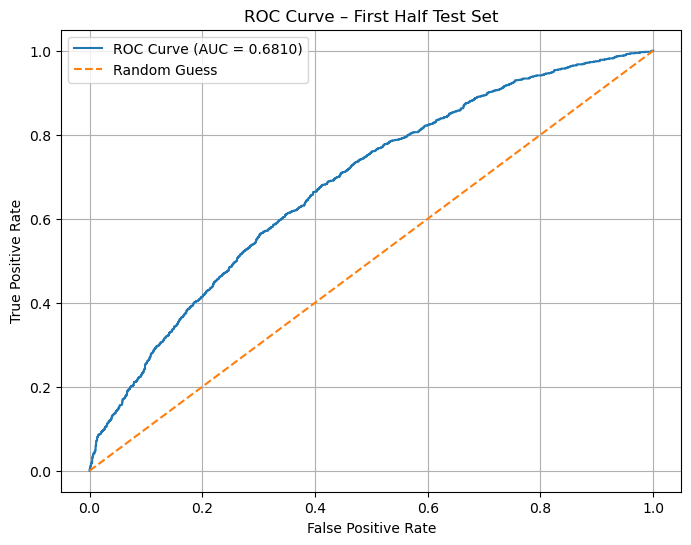

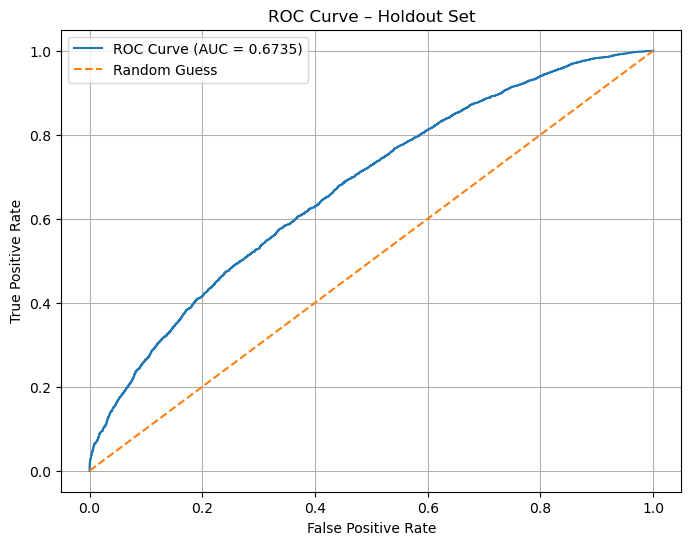

In [141]:
###### from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_eval, y_eval, title):
    # Get predicted probabilities
    y_proba = model.predict_proba(X_eval)[:, 1]

    # Compute ROC values
    fpr, tpr, _ = roc_curve(y_eval, y_proba)
    auc_score = roc_auc_score(y_eval, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 📈 ROC Curve for First Half Test Set
plot_roc_curve(
    model,
    X_test,
    y_test,
    title="ROC Curve – First Half Test Set"
)

# 📈 ROC Curve for Holdout Set
plot_roc_curve(
    model,
    X_second_half,
    y_second_half,
    title="ROC Curve – Holdout Set"
)


## Feature Importance Results and Interpretation

The feature importance scores extracted from the trained XGBoost model indicate how much each input variable contributes to predicting high rainfall events. Higher importance values suggest that a feature plays a more influential role in the model’s decision-making process.

The bar chart displays the top ten most important features, highlighting the rainfall-related variables that most strongly drive the classification of extreme rainfall events. This result provides interpretability to the model and helps connect predictive outcomes to meaningful rainfall characteristics, supporting a better understanding of the underlying patterns in the data.

C:\Users\aceho\AppData\Local\Temp\ipykernel_29348\1902498287.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')


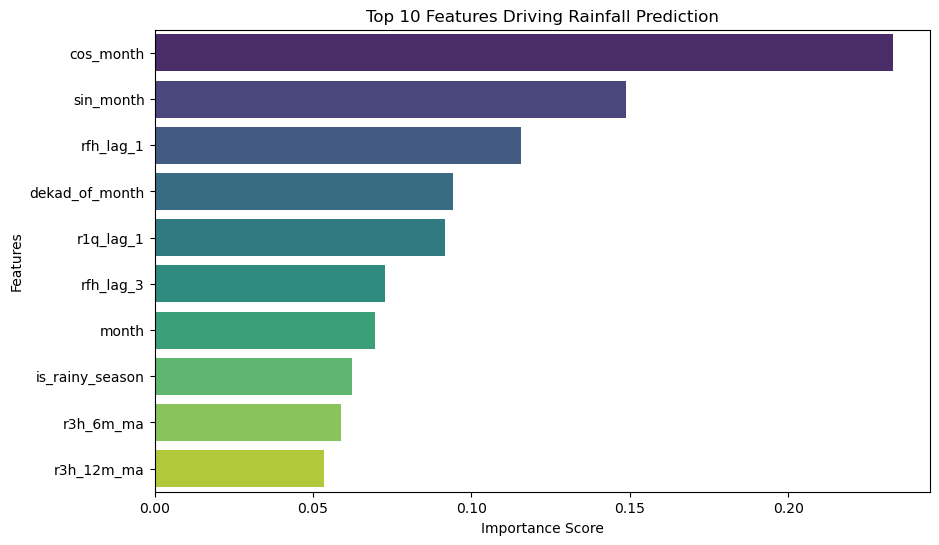

           Feature  Importance
7        cos_month    0.232907
6        sin_month    0.148650
0        rfh_lag_1    0.115687
4   dekad_of_month    0.094247
2        r1q_lag_1    0.091543
1        rfh_lag_3    0.072655
3            month    0.069524
5  is_rainy_season    0.062428
8        r3h_6m_ma    0.058808
9       r3h_12m_ma    0.053550


In [111]:
# Get feature importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features Driving Rainfall Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(feature_importance.head(10))

## Feature Importance for Real Forecasting

Feature importance analysis is conducted to identify the variables that most influence the prediction of high rainfall events under real forecasting conditions. The importance scores are derived from the trained XGBoost model and reflect the relative contribution of each feature to the model’s predictions.

The visualization highlights the top ten most influential features, providing insight into which rainfall-related indicators are most relevant for forecasting extreme rainfall. This analysis enhances model interpretability and supports practical understanding of the key drivers behind high rainfall predictions.

C:\Users\aceho\AppData\Local\Temp\ipykernel_29348\3791730278.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')


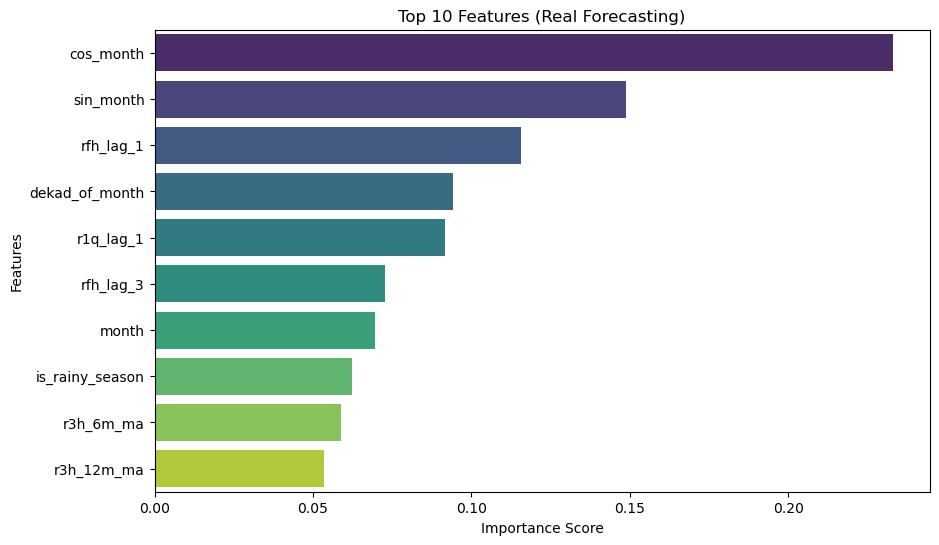

           Feature  Importance
7        cos_month    0.232907
6        sin_month    0.148650
0        rfh_lag_1    0.115687
4   dekad_of_month    0.094247
2        r1q_lag_1    0.091543
1        rfh_lag_3    0.072655
3            month    0.069524
5  is_rainy_season    0.062428
8        r3h_6m_ma    0.058808
9       r3h_12m_ma    0.053550


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the trained model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features (Real Forecasting)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(feature_importance.head(10))

## Final Model Evaluation on Holdout Data

The tuned model is evaluated on the holdout dataset, which represents completely unseen rainfall observations. This final evaluation provides a realistic assessment of the model’s performance in identifying high rainfall events under real-world conditions. Overall accuracy and a classification report are used to summarize predictive performance across both classes.

To further understand the model’s behavior, a confusion matrix is visualized. The confusion matrix shows the number of correctly and incorrectly classified observations, highlighting where the model makes accurate predictions and where misclassifications occur between normal and high rainfall events. This visualization offers a detailed view of model strengths and remaining limitations.

=== FINAL HOLDOUT RESULTS ===
Holdout Accuracy: 0.6913

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      7189
           1       0.63      0.60      0.61      4931

    accuracy                           0.69     12120
   macro avg       0.68      0.68      0.68     12120
weighted avg       0.69      0.69      0.69     12120



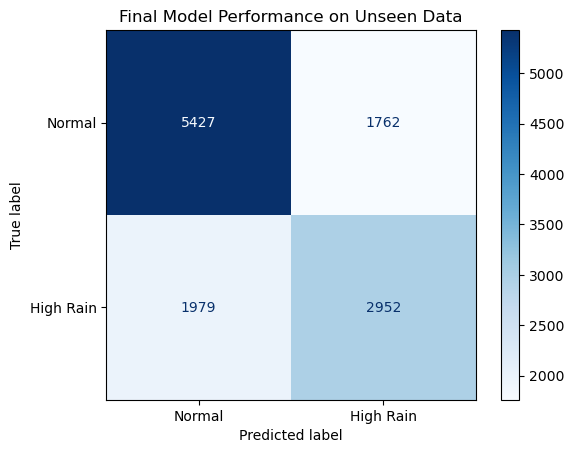

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predict on the Holdout Set (The Second Half)
y_pred_holdout_tuned = best_model.predict(X_second_half)
holdout_accuracy = accuracy_score(y_second_half, y_pred_holdout_tuned)

print("=== FINAL HOLDOUT RESULTS ===")
print(f"Holdout Accuracy: {holdout_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_second_half, y_pred_holdout_tuned))

# 2. Visualize the Confusion Matrix (To see exactly where it makes mistakes)
cm = confusion_matrix(y_second_half, y_pred_holdout_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "High Rain"])
disp.plot(cmap='Blues')
plt.title("Final Model Performance on Unseen Data")
plt.show()